Problem Statement

---

Developing a Convolutional Neural Network (CNN) model is crucial for precise melanoma detection, considering its life-threatening nature and the fact that it contributes to 75% of skin cancer fatalities. Early detection is paramount, and an automated solution capable of analyzing images to alert dermatologists about potential melanoma presence holds significant promise. Such a tool not only enhances diagnostic accuracy but also has the potential to alleviate the considerable manual effort currently required in the diagnosis process.



### Importing all the important libraries

In [1]:
!pip install Augmentor

In [3]:
# imports
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
from tensorflow import keras
from keras import layers
from keras.models import Sequential
import seaborn as sns
import Augmentor
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import load_img

### Data Reading/Data Understanding

This assignment is based on a dataset comprising approximately 2357 images representing various types of skin cancer. Within both the train and test subdirectories, there are 9 distinct sub-directories, each dedicated to images of a specific skin cancer type. This organizational structure allows for the classification and analysis of diverse skin cancer categories present in the dataset.

In [4]:
# dir
dir_train_data = pathlib.Path("./images/Train")
dir_test_data = pathlib.Path("./images/Test")

In [5]:
# train data count
count_train_data = len(list(dir_train_data.glob('*/*.jpg')))
print(f"Train Data Count: {count_train_data}")

Train Data Count: 2239


In [6]:
# test data count
count_test_data = len(list(dir_test_data.glob('*/*.jpg')))
print(f"Train Data Count: {count_test_data}")

Train Data Count: 118


### Dataset creation

In [6]:
# Define parameters for the data loader
loader_batch_size = 32  # Number of samples in each batch
loader_img_height = 180  # Height of the input images
loader_img_width = 180   # Width of the input images

Allocate 80% of the images for training purposes, while reserving the remaining 20% for validation to ensure an effective and unbiased assessment of the model's performance during the training process.

In [7]:
# Create a training dataset using 80% of the images
training_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dir_train_data,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(loader_img_height, loader_img_width),
    batch_size=loader_batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
# Create a validation dataset using 20% of the images
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dir_train_data,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(loader_img_height, loader_img_width),
    batch_size=loader_batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# Retrieve and print the class names from the training dataset
class_names = training_dataset.class_names
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

### Dataset visualisation

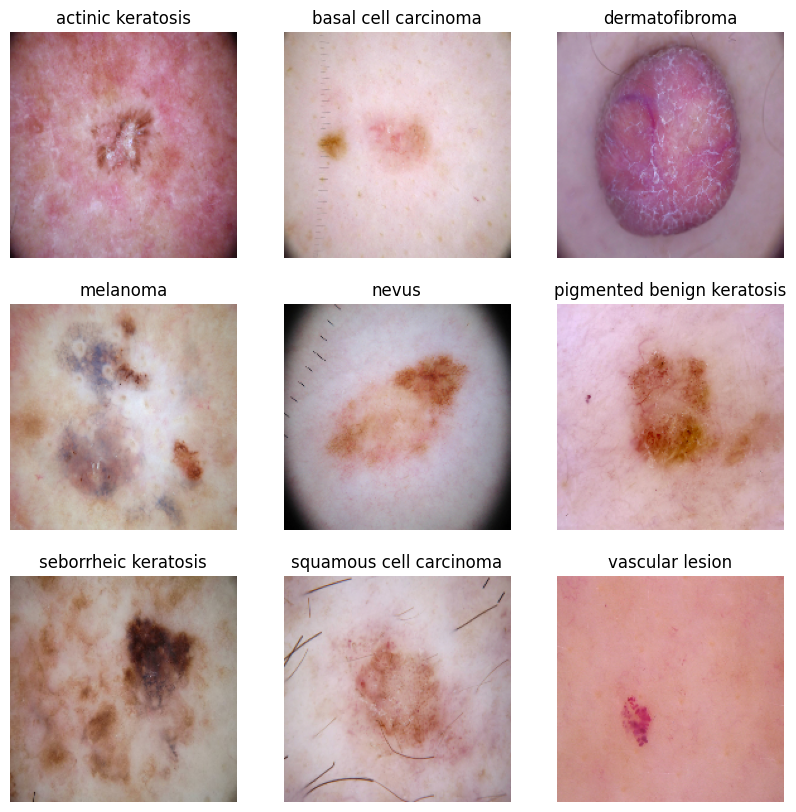

In [10]:
# Visualize a sample image from each class in the training dataset
plt.figure(figsize=(10, 10))

for i, class_name in enumerate(class_names):
    filtered_ds = training_dataset.filter(lambda x, l: tf.math.equal(l[0], i)).take(1)

    for image, label in filtered_ds:
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_name)
        plt.axis('off')

The image_batch is a tensor with dimensions (32, 180, 180, 3), representing a batch of 32 images, each with dimensions 180x180 pixels and three color channels (RGB). Simultaneously, the label_batch is a tensor of shape (32,), containing corresponding labels for the 32 images in the batch.

In [11]:
# Define AUTOTUNE for optimal performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Cache, shuffle, and prefetch the training dataset for improved performance
cached_and_shuffled_train_ds = training_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# Cache and prefetch the validation dataset for enhanced efficiency
cached_and_prefetched_val_ds = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Dataset.cache() retains images in memory after their initial loading from disk during the first epoch, optimizing subsequent epochs by avoiding redundant disk reads.

Conversely, Dataset.prefetch() facilitates concurrent data preprocessing and model execution during training, minimizing idle time and enhancing overall training efficiency.

### Model Building & Training

**Model Building**

Construct a Convolutional Neural Network (CNN) model designed for accurate detection of the 9 classes within the dataset. Utilize layers.experimental.preprocessing.Rescaling to normalize pixel values between (0, 1), addressing the non-ideal [0, 255] range of RGB channel values for optimal compatibility with neural network training.

In [12]:
# Define the number of classes based on the length of class_names
num_classes = len(class_names)

# Create a Sequential CNN model with Rescaling for normalization
cnn_model = Sequential([
    layers.Rescaling(1./255, input_shape=(loader_img_width, loader_img_height,3)),
    layers.Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
    layers.MaxPool2D(pool_size = (2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
    layers.MaxPool2D(pool_size = (2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
    layers.MaxPool2D(pool_size = (2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
    layers.MaxPool2D(pool_size = (2, 2)),
    layers.Conv2D(16, kernel_size=(7, 7),padding = 'Same',activation= 'relu'),
    layers.MaxPool2D(pool_size = (2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(128, kernel_size=(11,11),padding = 'Same',activation ='relu'),
    layers.MaxPool2D(pool_size = (2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(256, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
    layers.MaxPool2D(pool_size = (2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(num_classes,activation='softmax')
])

**Model Compliation**

Compile the CNN model by selecting a suitable optimizer, such as Adam, and an appropriate loss function, considering the multi-class classification nature of the task, to facilitate effective model training.

In [13]:
# Compile the CNN model with Adam optimizer, Sparse Categorical Crossentropy loss, and accuracy metric
cnn_model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

In [14]:
# Display a summary of the CNN model architecture, including layer information and parameter counts
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 90, 90, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                   

**Model Training**

In [15]:
# Set the number of training epochs
training_epochs = 20

# Train the CNN model using the specified training and validation datasets
training_history = cnn_model.fit(
    cached_and_shuffled_train_ds,
    validation_data=cached_and_prefetched_val_ds,
    epochs=training_epochs
)

Epoch 1/20
56/56 [==============================] - 17s 92ms/step - loss: 2.0879 - accuracy: 0.1758 - val_loss: 2.0466 - val_accuracy: 0.1790
Epoch 2/20
56/56 [==============================] - 3s 55ms/step - loss: 2.0266 - accuracy: 0.1987 - val_loss: 2.0244 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 3s 55ms/step - loss: 2.0193 - accuracy: 0.2003 - val_loss: 2.0248 - val_accuracy: 0.1924
Epoch 4/20
56/56 [==============================] - 3s 55ms/step - loss: 1.9256 - accuracy: 0.2623 - val_loss: 1.8962 - val_accuracy: 0.2819
Epoch 5/20
56/56 [==============================] - 3s 54ms/step - loss: 1.7349 - accuracy: 0.3292 - val_loss: 1.7006 - val_accuracy: 0.3423
Epoch 6/20
56/56 [==============================] - 3s 54ms/step - loss: 1.6817 - accuracy: 0.3610 - val_loss: 1.6949 - val_accuracy: 0.3982
Epoch 7/20
56/56 [==============================] - 3s 54ms/step - loss: 1.6523 - accuracy: 0.3772 - val_loss: 1.6126 - val_accuracy: 0.4027
Epoch 8/20
5

**Visualization of Training Results**

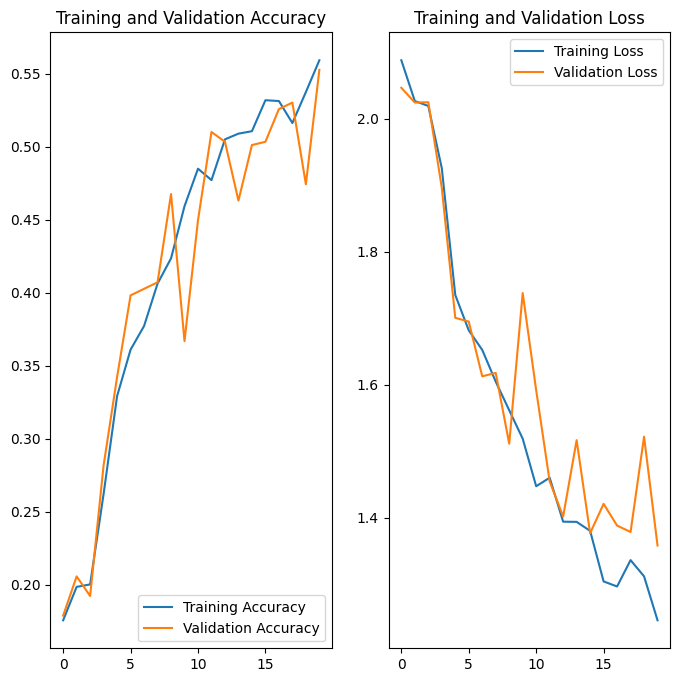

In [16]:
# Extracting accuracy and loss metrics from the training history
training_accuracy = training_history.history['accuracy']
validation_accuracy = training_history.history['val_accuracy']

training_loss = training_history.history['loss']
validation_loss = training_history.history['val_loss']

epochs_range = range(training_epochs)

# Plotting training and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Display the plots
plt.show()

**Key Findings**

* The significant gap between Training and Validation Accuracy suggests clear signs of overfitting in the model.
* Additionally, the achieved validation accuracy below 55% highlights the need for implementing strategies such as Data Augmentation and Dropout to effectively address and mitigate the overfitting challenges in the model training process.

### Data Augmentation

In [17]:
# Define a data augmentation sequential model
data_augmentation_model = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip(
            "horizontal_and_vertical",
            input_shape=(loader_img_width, loader_img_height, 3)
            ),
        layers.experimental.preprocessing.RandomRotation(0.2),
        layers.experimental.preprocessing.RandomZoom(0.2),
        layers.experimental.preprocessing.RandomContrast(0.1),
    ]
)

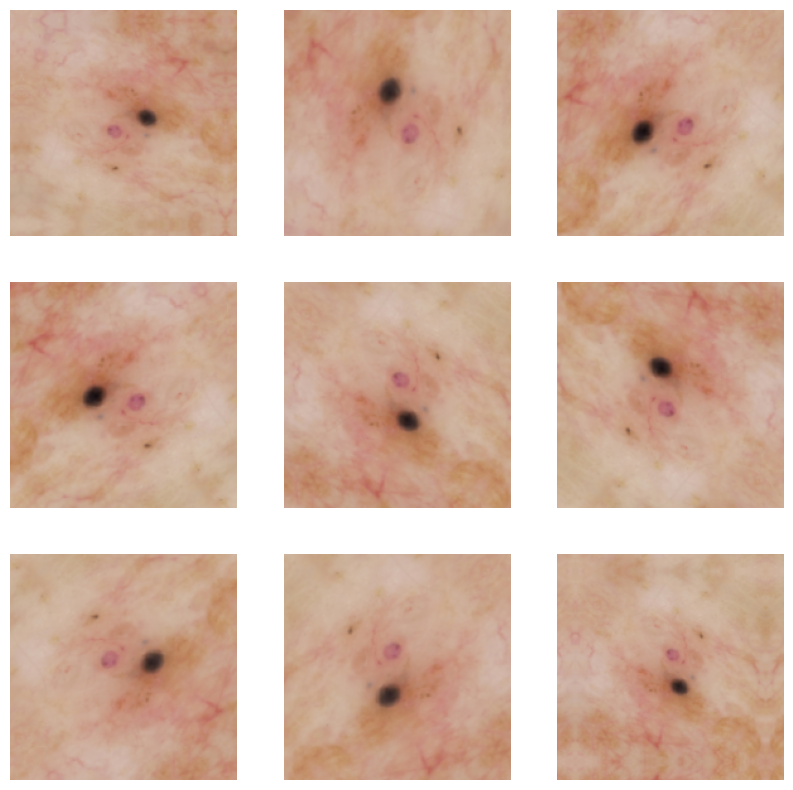

In [18]:
# Visualize augmented images using the data augmentation model
plt.figure(figsize=(10, 10))
for images, _ in cached_and_shuffled_train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation_model(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Model Building, Compilation, and Training with Data Augmentation**


**Model Building**

In [19]:
# Create a CNN model with data augmentation, rescaling, and dropout
augmented_model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(loader_img_width, loader_img_height,3)),
    data_augmentation_model,
    layers.Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
    layers.MaxPool2D(pool_size = (2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
    layers.MaxPool2D(pool_size = (2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
    layers.MaxPool2D(pool_size = (2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
    layers.MaxPool2D(pool_size = (2, 2)),
    layers.Conv2D(16, kernel_size=(7, 7),padding = 'Same',activation= 'relu'),
    layers.MaxPool2D(pool_size = (2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(128, kernel_size=(11, 11),padding = 'Same',activation ='relu'),
    layers.MaxPool2D(pool_size = (2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(256, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
    layers.MaxPool2D(pool_size = (2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(9,activation='softmax'),
])

**Model Compilation**

In [20]:
# Compile the augmented model with Adam optimizer, Sparse Categorical Crossentropy loss, and accuracy metric
augmented_model.compile(optimizer='adam',
                        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                        metrics=['accuracy'])

In [21]:
# Displaying the summary of the augmented model architecture
augmented_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 90, 90, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 90, 90, 64)        18496     
                                                      

**Model Training**

In [22]:
# Train the augmented model using the specified training and validation datasets
augmented_training_history = augmented_model.fit(
    cached_and_shuffled_train_ds,
    validation_data=cached_and_prefetched_val_ds,
    epochs=training_epochs
)

Epoch 1/20
56/56 [==============================] - 6s 62ms/step - loss: 2.0553 - accuracy: 0.1881 - val_loss: 2.0760 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 3s 57ms/step - loss: 2.0267 - accuracy: 0.2087 - val_loss: 2.0582 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 3s 55ms/step - loss: 2.0231 - accuracy: 0.2154 - val_loss: 2.0191 - val_accuracy: 0.1924
Epoch 4/20
56/56 [==============================] - 3s 55ms/step - loss: 1.9034 - accuracy: 0.2829 - val_loss: 1.7720 - val_accuracy: 0.3333
Epoch 5/20
56/56 [==============================] - 3s 54ms/step - loss: 1.8770 - accuracy: 0.2796 - val_loss: 1.9126 - val_accuracy: 0.2931
Epoch 6/20
56/56 [==============================] - 3s 54ms/step - loss: 1.8189 - accuracy: 0.3086 - val_loss: 1.7407 - val_accuracy: 0.3199
Epoch 7/20
56/56 [==============================] - 3s 55ms/step - loss: 1.7295 - accuracy: 0.3287 - val_loss: 1.7027 - val_accuracy: 0.3781
Epoch 8/20
56

**Visualization of Augmented Model Training Results**

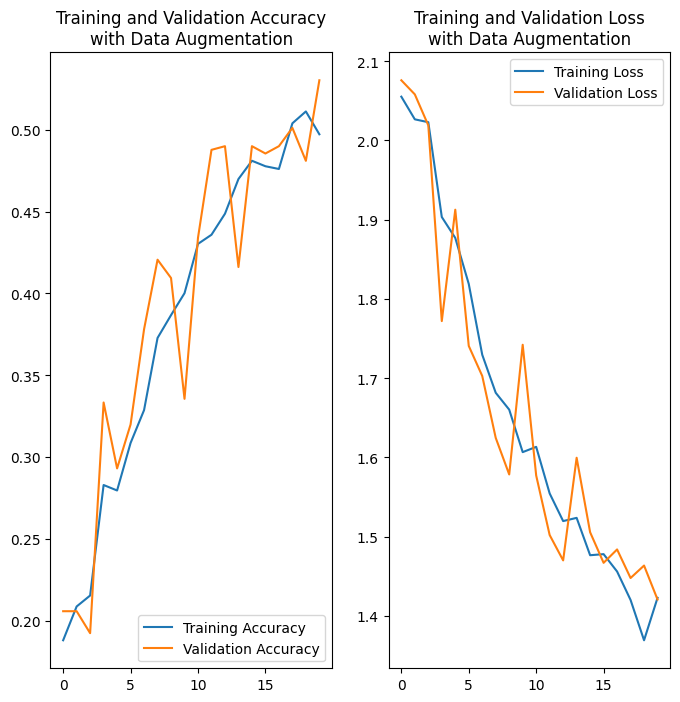

In [23]:
# Extracting accuracy and loss metrics from the augmented model training history
augmented_training_accuracy = augmented_training_history.history['accuracy']
augmented_validation_accuracy = augmented_training_history.history['val_accuracy']

augmented_training_loss = augmented_training_history.history['loss']
augmented_validation_loss = augmented_training_history.history['val_loss']

epochs_range = range(training_epochs)

# Plotting training and validation accuracy with a line break in the title
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, augmented_training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, augmented_validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy\nwith Data Augmentation')  # Add a line break

# Plotting training and validation loss with a line break in the title
plt.subplot(1, 2, 2)
plt.plot(epochs_range, augmented_training_loss, label='Training Loss')
plt.plot(epochs_range, augmented_validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss\nwith Data Augmentation')  # Add a line break

# Display the plots
plt.show()

**Key Findings**

  While the Training and Validation accuracy have significantly converged, reaching a peak of around 60%, the noticeable alignment underscores the positive impact of Data Augmentation in enhancing model performance. However, there remains an opportunity to further improve the accuracy of the model.

### Class Distribution Analysis in the Training Dataset

Considering the potential impact of class imbalance on model quality, it becomes crucial to perform a thorough analysis of the class distribution in real-life datasets. Class imbalance, where one class has a significantly higher number of samples compared to others, can adversely affect the model's performance, making it imperative to conduct this analysis as a sanity check.

In [24]:
def get_class_distribution_count(directory):
    """
    Count the number of images in each class within the specified directory.

    Parameters:
    - directory (str): The path to the directory containing class sub-directories.

    Returns:
    - pandas.DataFrame: A DataFrame with columns 'Class' and 'No. of Images'.
    """
    # Count the number of images in each class
    class_counts = []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            class_counts.append(len([name for name in os.listdir(path)
                                     if os.path.isfile(os.path.join(path, name))]))

    # Extract class names
    class_names = [name for name in os.listdir(directory)
                   if os.path.isdir(os.path.join(directory, name))]

    # Return a DataFrame with image count and class
    return pd.DataFrame(list(zip(class_names, class_counts)), columns=['Class', 'No. of Images'])

In [25]:
# Generate a DataFrame summarizing the class distribution in the training dataset
class_distribution_df = get_class_distribution_count(dir_train_data)

# Display the DataFrame
class_distribution_df

,Class,No. of Images
0,basal cell carcinoma,376
1,actinic keratosis,114
2,melanoma,438
3,nevus,357
4,dermatofibroma,95
5,pigmented benign keratosis,462
6,vascular lesion,139
7,seborrheic keratosis,77
8,squamous cell carcinoma,181


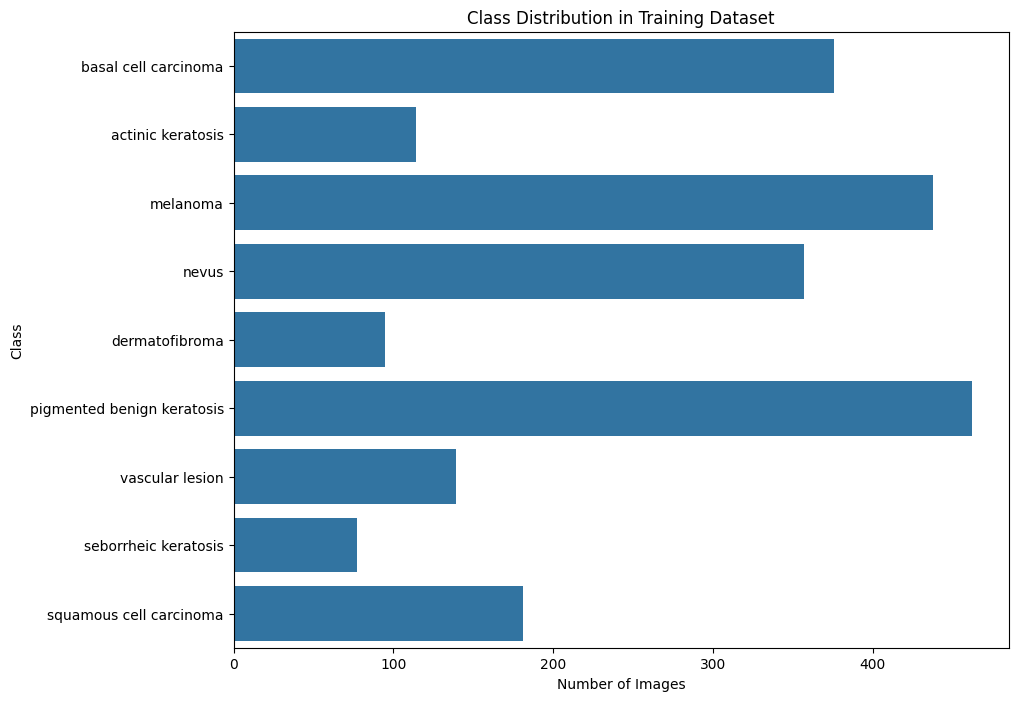

In [26]:
# Visualize the class distribution using a bar plot
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Images", y="Class", data=class_distribution_df)

# Adding labels and title
plt.xlabel("Number of Images")
plt.ylabel("Class")
plt.title("Class Distribution in Training Dataset")

# Show the plot
plt.show()

**Key Findings**

- Which class has the least number of samples?

  Ans: The bar chart reveals that the class 'seborrheic keratosis' has the fewest number of samples among all classes in the dataset.

- Which classes dominate the data in terms proportionate number of samples?

  Ans: Among all the classes, it is evident that 'pigmented benign keratosis' has the highest number of samples based on the observed distribution.

### Handling class imbalances

Augmentor, a Python package, can be utilized to augment the dataset by generating additional samples across all classes, effectively mitigating the issue of class imbalance and ensuring a more balanced representation of each class.

To employ Augmentor, follow these steps:
- Instantiate a Pipeline object, specifying the directory with your initial image dataset.
- Define a series of operations using the Pipeline object.
- Execute these operations by invoking the sample() method of the Pipeline.

In [27]:
# Augment each class in the dataset
for class_name in class_names:
    class_path = os.path.join(dir_train_data, class_name)

    # Create an Augmentor Pipeline for the current class
    pipeline = Augmentor.Pipeline(class_path)

    # Define augmentation operations
    pipeline.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)

    # Generate 500 augmented samples per class
    pipeline.sample(500)

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/images/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C9EE23A19C0>: 100%|██████████| 500/500 [00:04<00:00, 101.13 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/images/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C9F300754E0>: 100%|██████████| 500/500 [00:05<00:00, 95.27 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/images/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7C9F54127070>: 100%|██████████| 500/500 [00:05<00:00, 97.82 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/images/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1936x1936 at 0x7CA011C21A50>: 100%|██████████| 500/500 [00:19<00:00, 25.64 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/images/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=824x719 at 0x7C9F485F20B0>: 100%|██████████| 500/500 [00:18<00:00, 26.81 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/images/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7C9EE23A1990>: 100%|██████████| 500/500 [00:05<00:00, 92.67 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/images/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7CA011BDEDA0>: 100%|██████████| 500/500 [00:08<00:00, 59.94 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/images/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C9F485380A0>: 100%|██████████| 500/500 [00:05<00:00, 94.14 Samples/s] 


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/images/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7CA012A6ED10>: 100%|██████████| 500/500 [00:05<00:00, 97.03 Samples/s]


After applying augmentation using Augmentor, the augmented images have been stored in the 'output' sub-directory within each sub-directory corresponding to different skin cancer types. Let's now examine the total count of augmented images.

In [7]:
# Count the total number of augmented images in the training dataset
augmented_image_count_train = len(list(dir_train_data.glob('*/output/*.jpg')))
augmented_image_count_train

4500

Let's examine the distribution of the augmented data after incorporating new images into the original training dataset.

In [8]:
# Retrieve the paths of the newly augmented images
augmented_image_paths = list(glob(os.path.join(dir_train_data, '*', 'output', '*.jpg')))

# Display the list of paths for the augmented images
augmented_image_paths

['images/Train/melanoma/output/melanoma_original_ISIC_0011132.jpg_b071e414-892e-49ca-80cb-66ccb92fbf8b.jpg',
 'images/Train/melanoma/output/melanoma_original_ISIC_0010878.jpg_af79849d-aeaa-409f-a3af-08aecc12d1e6.jpg',
 'images/Train/melanoma/output/melanoma_original_ISIC_0010207.jpg_156a85b0-ec56-4f41-a269-4ae62504cb5f.jpg',
 'images/Train/melanoma/output/melanoma_original_ISIC_0010194.jpg_500098c3-0e04-4fb8-9921-72dba1a6c4ec.jpg',
 'images/Train/melanoma/output/melanoma_original_ISIC_0010808.jpg_3c124b9a-c866-4823-8af2-2a33b16d8eeb.jpg',
 'images/Train/melanoma/output/melanoma_original_ISIC_0010917.jpg_c2409724-eefa-44a8-a9ec-44794bc2d80e.jpg',
 'images/Train/melanoma/output/melanoma_original_ISIC_0011039.jpg_bf3afa2c-0993-4d87-b249-2924b0b99931.jpg',
 'images/Train/melanoma/output/melanoma_original_ISIC_0010067.jpg_5ee1db6a-d975-4db2-8e92-b8f63f9b7c9a.jpg',
 'images/Train/melanoma/output/melanoma_original_ISIC_0011138.jpg_f8d81417-e397-48c7-bf2a-85c84ae0b4b6.jpg',
 'images/Train/mela

In [9]:
# Retrieve the labels (lesion types) for the newly augmented images
augmented_image_list = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(dir_train_data, '*', 'output', '*.jpg'))]

# Display the list of lesion labels for the augmented images
augmented_image_list

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [31]:
# Create a dictionary mapping the paths of augmented images to their corresponding labels
augmented_image_dict = dict(zip(augmented_image_paths, augmented_image_list))

In [32]:
# Iterate through each class name
for class_name in class_names:
    # Define the directory paths
    dir_temp = os.path.join(dir_train_data, class_name, "output")
    dir_train_output_data = pathlib.Path(dir_temp)

    # Count the number of original and augmented samples for the current class
    original_samples_count = len(list(dir_train_data.glob(class_name + '/*.jpg')))
    augmented_samples_count = len(list(dir_train_output_data.glob('*.jpg')))

    # Calculate the total number of samples
    total_samples_count = original_samples_count + augmented_samples_count

    # Print the total number of samples for the current class
    print(f'{class_name:<30} : {total_samples_count}')


actinic keratosis              : 614
basal cell carcinoma           : 876
dermatofibroma                 : 595
melanoma                       : 938
nevus                          : 857
pigmented benign keratosis     : 962
seborrheic keratosis           : 577
squamous cell carcinoma        : 681
vascular lesion                : 639


Now, have augmented each class with an additional 500 images to address the class imbalance, have the flexibility to further enhance the training process by adding more images as needed.

### Model Building & Training on Augmented Data

In [33]:
# Create a training dataset using the augmented data directory
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dir_train_data,
    seed=123,
    validation_split=0.2,
    subset="training",
    image_size=(loader_img_height, loader_img_width),
    batch_size=loader_batch_size
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [34]:
# Create a validation dataset using the augmented data directory
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dir_train_data,
    seed=123,
    validation_split=0.2,
    subset="validation",
    image_size=(loader_img_height, loader_img_width),
    batch_size=loader_batch_size
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


**Creating the Model with Normalization**

In [35]:
# Create the model architecture with data augmentation and normalization
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)),
    layers.Conv2D(32,kernel_size=(3,3),activation='relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Conv2D(128,kernel_size=(3,3),activation='relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Conv2D(256,kernel_size=(11,11),activation='relu'),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(256,activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(128,activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(64,activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(len(class_names),activation='softmax')
])

**Compiling the Model with Optimizer and Loss Function**

In [36]:
# Compile the model with appropriate optimizer, loss function, and metrics
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [37]:
# Display a summary of the model architecture
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 41, 41, 128)      

In [38]:
# Create a ReduceLROnPlateau callback to adjust learning rate based on validation accuracy
learning_rate_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                          verbose=1, factor=0.2, min_lr=1e-7)

**Training the Model**

In [39]:
# Define the number of epochs for training
num_epochs = 50

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=num_epochs,
    callbacks=[learning_rate_control]
)

Epoch 1/50
169/169 [==============================] - 25s 120ms/step - loss: 2.1855 - accuracy: 0.1293 - val_loss: 2.1816 - val_accuracy: 0.1403 - lr: 0.0010
Epoch 2/50
169/169 [==============================] - 19s 106ms/step - loss: 2.0394 - accuracy: 0.1955 - val_loss: 1.8634 - val_accuracy: 0.2554 - lr: 0.0010
Epoch 3/50
169/169 [==============================] - 19s 108ms/step - loss: 1.8336 - accuracy: 0.2589 - val_loss: 1.7934 - val_accuracy: 0.3163 - lr: 0.0010
Epoch 4/50
169/169 [==============================] - 18s 105ms/step - loss: 1.8082 - accuracy: 0.2875 - val_loss: 1.8416 - val_accuracy: 0.2888 - lr: 0.0010
Epoch 5/50
169/169 [==============================] - 18s 105ms/step - loss: 1.7104 - accuracy: 0.3279 - val_loss: 1.6931 - val_accuracy: 0.3296 - lr: 0.0010
Epoch 6/50
169/169 [==============================] - 18s 105ms/step - loss: 1.7069 - accuracy: 0.3466 - val_loss: 1.7258 - val_accuracy: 0.3215 - lr: 0.0010
Epoch 7/50
169/169 [==============================] 

**Visualizing Model Results**

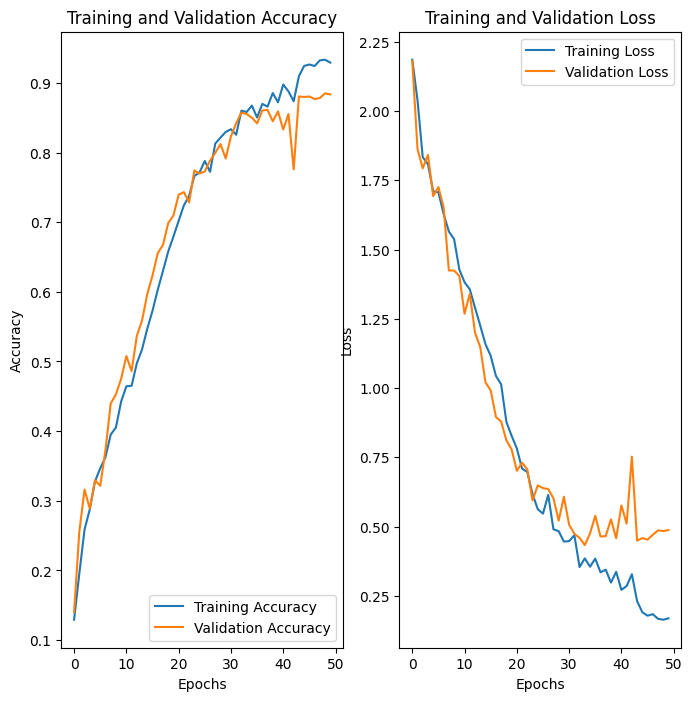

In [40]:
# Retrieve the training and validation accuracy and loss values from the training history
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Define the number of epochs
epochs_range = range(num_epochs)

# Plotting the training and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Plotting the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Display the plots
plt.show()

### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

**Key Findings**

The similar training and validation accuracy, as well as the comparable training and validation loss, indicate that the model has achieved a good fit to the data. With a validation accuracy of 0.88, the model demonstrates an ability to classify images with 92% accuracy, making it a reliable tool for predicting skin cancer using convolutional neural networks.

**Testing the Model**

1/1 [==============================] - 0s 340ms/step
Actual Class    : basal cell carcinoma
Predicted Class : pigmented benign keratosis


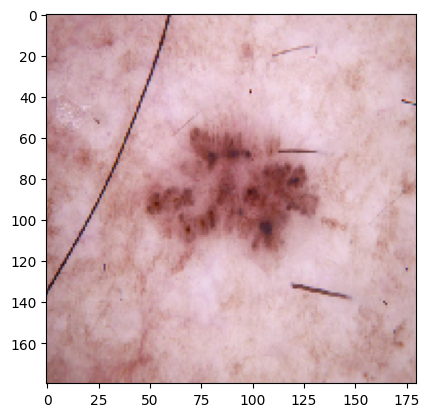

In [41]:
# Set the index for the class name
class_name_index = 1

# Define the path to the test image
test_image_path = os.path.join(dir_test_data, class_names[class_name_index], '*')

# Load the test image
test_image = glob(test_image_path)
test_image = load_img(test_image[-1], target_size=(180, 180, 3))

# Display the test image
plt.imshow(test_image)
plt.grid(False)

# Preprocess the image
img = np.expand_dims(test_image, axis=0)

# Make predictions using the model
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]

# Print the actual and predicted class labels
print(f"Actual Class    : {class_names[class_name_index]}")
print(f"Predicted Class : {pred_class}")